In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import 
import os
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor
from hmmlearn import hmm

In [3]:
#from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch
from uncertainty_motion_prediction.predictor import normalise_segment_batch


# Load the Dataset and Overview of the Data

Load and Data and conduct some brief analysis on the pattern of the normalised segment.

In [4]:
#Switch the dataset
'''
0: eth-univ
1: eth-hotel
2: ucy-zara1
3: ucy-zara2
4: ucy-univ3
'''
dataset_no = 5

In [5]:
dataset=Dataloader();
traj_dataset = dataset.load(dataset_no)

In [6]:
segment_length = 4
num_segment = 4# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

#Start by instantiating a HMM with continuous Gaussian emission distributions.
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length =num_segment * segment_length*0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(1550, 16, 5)


In [7]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])



In [8]:
#take a look at the data
df = pd.DataFrame(normalised)
df.describe()

,0,1,2,3,4,5,6,7
count,6200.0,6200.000000,6200.000000,6200.000000,6200.0,6.200000e+03,6.200000e+03,6.200000e+03
mean,0.0,0.318318,0.633287,0.945939,0.0,9.124376e-04,2.580991e-03,4.977507e-03
std,0.0,0.043918,0.087246,0.134528,0.0,2.125660e-02,5.316890e-02,9.509262e-02
min,0.0,-0.144740,-0.337319,-0.584074,0.0,-1.426338e-01,-3.326145e-01,-5.884717e-01
25%,0.0,0.318925,0.640555,0.962039,0.0,-1.228653e-13,-1.140261e-02,-3.127037e-02
50%,0.0,0.331165,0.660455,0.988846,0.0,0.000000e+00,1.387779e-17,1.387779e-16
75%,0.0,0.334276,0.666667,0.997712,0.0,7.094795e-04,1.471153e-02,3.710695e-02
max,0.0,0.374010,0.686689,1.000000,0.0,1.964723e-01,3.929446e-01,5.894168e-01


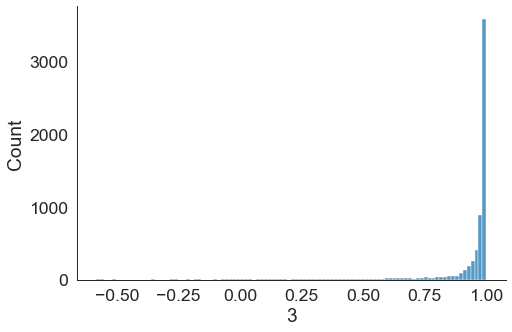

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x=3, kind="hist", bins = 100, aspect = 1.5)


In [10]:
# Pair-wise Scatter Plots
#pp = sns.pairplot(df, size=1.8, aspect=1.8,
#                  plot_kws=dict(edgecolor="k", linewidth=0.5),
#                  diag_kind="kde", diag_kws=dict(shade=True))

#fig = pp.fig 
#fig.subplots_adjust(top=0.93, wspace=0.3)
#t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)


# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

Start by instantiating a HMM with continuous Gaussian emission distributions.

In [11]:
if dataset_no == 0:
    # ETC Uni
    n_components = 10
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 1:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 2:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 3:
    # ETC Hotel
    n_components = 4
    covariance_type = "full"
    n_iter = 50
elif dataset_no == 4:
    # ucy-univ3
    n_components = 10
    covariance_type = "full"
    n_iter = 80
elif dataset_no == 5:
    # ucy-univ3
    n_components = 4
    covariance_type = "full"
    n_iter = 80


model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, 
                        init_params='stmc', n_iter=n_iter, verbose=True)

Preprocess the trajectories by normalising them (without the adjustment on Rotation). Then we estimate the model parameters (transition matrix and Gaussian emission distribution parameters).

In [12]:
var_param = 1
covar = np.array ([[1, 0., 0., 0., 0., 0., 0., 0.],
                  [0., 1, 1, 1, 0., 0., 0., 0.],
                   [0., 1, 1, 1, 0., 0., 0., 0.],
                   [0., 1, 1, 1, 0., 0., 0., 0.],
                    [0., 0, 0, 0, 1, 0., 0., 0.],
                    [0., 0, 0, 0, 0, 1, 1, 1],
                    [0., 0, 0, 0, 0, 1, 1, 1],
                    [0., 0, 0, 0, 0, 1, 1, 1]])



covars = var_param* np.tile(covar, (n_components, 1, 1))


In [13]:
#model.covars_ = covars

In [14]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])

model.fit(normalised[:,np.r_[1:4,5:8]], lengths=sequence_lengths)

         1       62177.9920             +nan
         2       97415.2204      +35237.2284
         3      104441.6237       +7026.4033
         4      106183.4221       +1741.7984
         5      107246.3373       +1062.9151
         6      108101.8566        +855.5193
         7      108783.0701        +681.2136
         8      109329.2177        +546.1475
         9      109798.1128        +468.8951
        10      110177.4792        +379.3664
        11      110470.1569        +292.6777
        12      110714.0522        +243.8953
        13      110936.3295        +222.2774
        14      111154.6159        +218.2864
        15      111378.2905        +223.6745
        16      111604.7035        +226.4131
        17      111824.9103        +220.2068
        18      112041.0239        +216.1136
        19      112255.7441        +214.7202
        20      112449.3836        +193.6395
        21      112636.7320        +187.3484
        22      112876.5048        +239.7729
        23

GaussianHMM(covariance_type='full', n_components=4, n_iter=80, verbose=True)

In [15]:
model.covars_

array([[[ 2.19472798e-05,  3.90963715e-05,  1.52683648e-05,
          5.90432314e-06,  7.14333362e-06,  7.50428632e-06],
        [ 3.90963715e-05,  7.32500278e-05,  2.63806174e-05,
          8.29831330e-06,  1.18128969e-05,  1.42837817e-05],
        [ 1.52683648e-05,  2.63806174e-05,  4.37151483e-05,
          7.43655188e-06,  1.06958166e-05,  1.59898530e-05],
        [ 5.90432314e-06,  8.29831330e-06,  7.43655188e-06,
          8.58152064e-05,  1.68388350e-04,  2.49673963e-04],
        [ 7.14333362e-06,  1.18128969e-05,  1.06958166e-05,
          1.68388350e-04,  3.34999684e-04,  5.00302585e-04],
        [ 7.50428632e-06,  1.42837817e-05,  1.59898530e-05,
          2.49673963e-04,  5.00302585e-04,  8.84120874e-04]],

       [[ 6.57760445e-03,  1.15469759e-02,  1.48225451e-02,
         -1.80144730e-04, -5.08655588e-04, -1.01274644e-03],
        [ 1.15469759e-02,  2.43110886e-02,  3.46910147e-02,
         -4.08616351e-04, -1.14407969e-03, -2.26141661e-03],
        [ 1.48225451e-02,  3.4

In [16]:
import pickle
with open('gaussian_hmm_%s.pkl'%dataset_no, 'wb') as file:
    pickle.dump(model, file)


In [17]:
model.transmat_

array([[0.57005083, 0.12704363, 0.22189129, 0.08101425],
       [0.221734  , 0.45863413, 0.1901505 , 0.12948137],
       [0.24261833, 0.12138678, 0.49249778, 0.14349711],
       [0.26700212, 0.22443165, 0.32890073, 0.1796655 ]])

Set up to test the model.

In [18]:
trajlets_for_testing = traj_dataset.get_trajlets(
    length=segment_length * num_segment * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(803, 16, 5)


A sanity check for our predictor and model, to visually inspect if the predict function works and yields reasonable values.

In [19]:
traj = trajlets_for_hmm_learning[0, :, :]

In [20]:
import pickle

model = None
with open('gaussian_hmm_%s.pkl'%dataset_no, 'rb') as file:
    model = pickle.load(file)
    
predictor = HMMContinuousEmissionsPredictor(hmm = model)
print(traj.shape)
print(predictor.predict(traj))

(16, 5)
[[11.24436313  2.24996693]
 [11.90667305  2.25058915]
 [12.56552356  2.24381591]
 [13.22399178  2.23213658]]


Compute the ADE and FDE of the model.

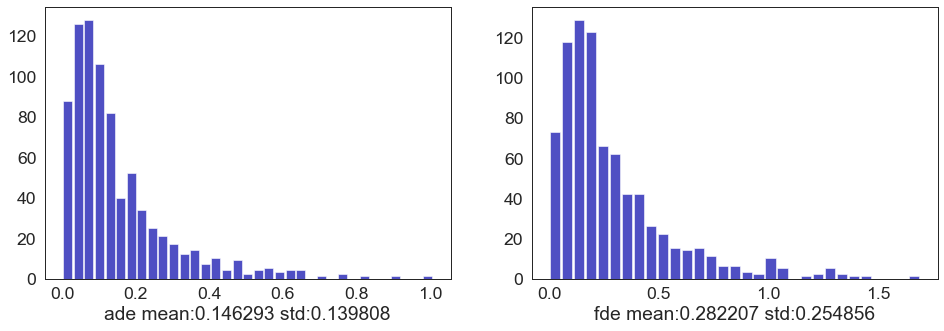

In [21]:
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(predictor, trajlets_for_testing)
evaluator.hist()
res_state = evaluator.statistic()